#**Importing Packages**

In [ ]:
!pip install transformers
!pip install torch

In [ ]:
import numpy as np
import torch
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Datasets**

**Reading datasets**

In [ ]:
trai_dset=pd.read_csv("/content/drive/MyDrive/tam-sentiment-train.csv")
dev_dset=pd.read_csv("/content/drive/MyDrive/tam-sentiment-dev.csv")
tes_dset=pd.read_csv("/content/drive/MyDrive/sen_tam_test_without_labels.csv")

**Dimensions of datasets**

In [ ]:
print("Training dataset = {}\nDevelopment dataset = {}\nTest dataset ={}".format(trai_dset.shape,dev_dset.shape,tes_dset.shape))

Training dataset = (33989, 2)
Development dataset = (3786, 2)
Test dataset =(649, 2)


**Label-Count in training and development dataset**

In [ ]:
print("\t\tTraining dataset\n{}\n\n\t\tDevelopment dataset\n{}".format(trai_dset["category"].value_counts(),dev_dset["category"].value_counts()))

		Training dataset
Positive          20070
unknown_state      5628
Negative           4271
Mixed_feelings     4020
Name: category, dtype: int64

		Development dataset
Positive          2257
unknown_state      611
Negative           480
Mixed_feelings     438
Name: category, dtype: int64


**Combining Training data and development data**

In [ ]:
dset=pd.concat([trai_dset,dev_dset])
print("Training dataset = {}\nDevelopment dataset = {}\nCombined dataset ={}".format(trai_dset.shape,dev_dset.shape,dset.shape))

Training dataset = (33989, 2)
Development dataset = (3786, 2)
Combined dataset =(37775, 2)


# **Preprocessing**

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
dset['text'] = dset['text'].apply(nltk.word_tokenize)
dset['text'] = dset['text'].apply(lambda x: [word.lower() for word in x])

In [ ]:
stop_words = set(stopwords.words('english'))
dset['text'] = dset['text'].apply(lambda x: [word for word in x if word not in stop_words])

In [ ]:
dlabel=trai_dset.category.factorize()
oov_tok = '<OOV>'
dlabel[0]

array([0, 1, 1, ..., 2, 1, 1])

In [ ]:
tot_text = dset.text.values

In [ ]:
tokenizer = Tokenizer(num_words=7000,oov_token=oov_tok)
tokenizer.fit_on_texts(tot_text)
dset_vocab_size = len(tokenizer.word_index) + 1
dset_encoded_docs = tokenizer.texts_to_sequences(tot_text)
dset_padded_sequence = pad_sequences(dset_encoded_docs, maxlen=200,padding="post",truncating='post')

In [ ]:
print(tokenizer.word_index)

{'<OOV>': 1, '...': 2, '.': 3, ',': 4, '..': 5, '!': 6, 'like': 7, 'thala': 8, '....': 9, '?': 10, 'trailer': 11, 'mass': 12, 'vera': 13, 'படம்': 14, 'la': 15, 'padam': 16, 'level': 17, 'da': 18, 'movie': 19, 'வாழ்த்துக்கள்': 20, 'fans': 21, 'ah': 22, 'super': 23, '#': 24, 'anna': 25, 'சார்பாக': 26, '.....': 27, 'sir': 28, 'oru': 29, 'வெற்றி': 30, 'waiting': 31, 'ku': 32, 'surya': 33, 'nu': 34, 'vijay': 35, 'semma': 36, 'இந்த': 37, 'iruku': 38, 'பெற': 39, 'hit': 40, 'bgm': 41, 'intha': 42, 'likes': 43, 'marana': 44, 'love': 45, 'sema': 46, 'fan': 47, 'enna': 48, 'teaser': 49, 'na': 50, 'views': 51, 'ஒரு': 52, ')': 53, 'suriya': 54, 'illa': 55, 'va': 56, '......': 57, 'rajini': 58, 'nalla': 59, 'u': 60, ':': 61, 'தான்': 62, '(': 63, 'ajith': 64, 'ngk': 65, 'irukku': 66, 'thalaivar': 67, 'thalaiva': 68, 'ithu': 69, 'indha': 70, 'music': 71, 'tha': 72, 'சாதி': 73, 'dislike': 74, 'ya': 75, 'pola': 76, 'thalapathy': 77, 'pakka': 78, 'mattum': 79, 'dialogue': 80, '-': 81, 'podunga': 82, 'tam

In [ ]:
print(dset_encoded_docs[0],dset.text[0])

[1245, 1, 21, 40, 7, 496, 1479, 7, 1, 2232] 0    [vani, bhojam, fans, hit, like, solli, 500, li...
0    [@, 0:40, songsuperb, .., kamallllla, .., 'm, ...
Name: text, dtype: object


# **Machine Learning**

**Split data into train and test**

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(dset_padded_sequence,dset.category,test_size=0.3)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((26442, 200), (26442,), (11333, 200), (11333,))

In [ ]:
label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test= label_encoder.transform(y_test)

**Importing Machine Learning models**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

**Training models with training data**

In [ ]:
RF=RandomForestClassifier(n_estimators=7)
DT=DecisionTreeClassifier()
LR=LogisticRegression()
NB=GaussianNB()
algorithms=dict(zip(["RandomForest","DecisionTree","LogisticRegression","GaussianNB"],[RF,DT,LR,NB]))
algo_names=["RandomForest","DecisionTree","LogisticRegression","GaussianNB"]
for mod in algo_names:
  algorithms[mod].fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


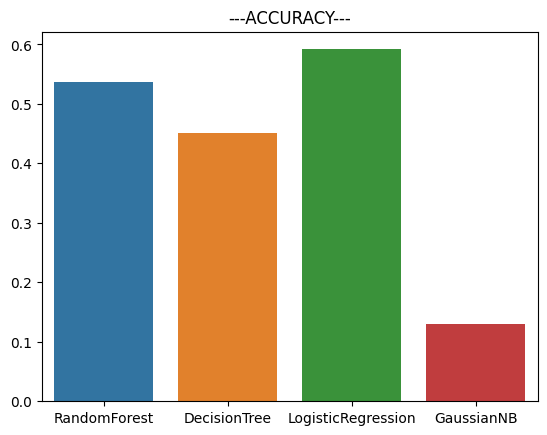

In [ ]:
classes=['Mixed_feelings', 'Negative', 'Positive',"unknown_state"]
ac=[accuracy_score(y_test,algorithms[j].predict(x_test)) for j in algo_names]
cm=[ConfusionMatrixDisplay(confusion_matrix(y_test,algorithms[j].predict(x_test)),display_labels=classes)  for j in algo_names]
cr=['\t\t\t'+j+'\n\n'+classification_report(y_test,algorithms[j].predict(x_test))+'\n\n'  for j in algo_names]
sns.barplot(x=algo_names,y=ac)
plt.title("---ACCURACY---")
plt.show()

**Classification report for machine learning model**

In [ ]:
for i in cr:
  print(i)

			RandomForest

              precision    recall  f1-score   support

           0       0.21      0.15      0.18      1351
           1       0.17      0.10      0.13      1436
           2       0.63      0.81      0.71      6727
           3       0.31      0.14      0.19      1819

    accuracy                           0.54     11333
   macro avg       0.33      0.30      0.30     11333
weighted avg       0.47      0.54      0.49     11333



			DecisionTree

              precision    recall  f1-score   support

           0       0.18      0.19      0.18      1351
           1       0.16      0.15      0.16      1436
           2       0.65      0.62      0.64      6727
           3       0.21      0.24      0.22      1819

    accuracy                           0.45     11333
   macro avg       0.30      0.30      0.30     11333
weighted avg       0.46      0.45      0.46     11333



			LogisticRegression

              precision    recall  f1-score   support

           0  

**confusion matrix for machine learning model**

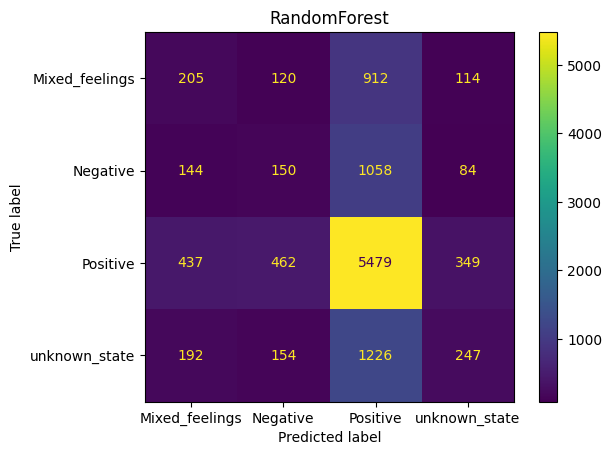

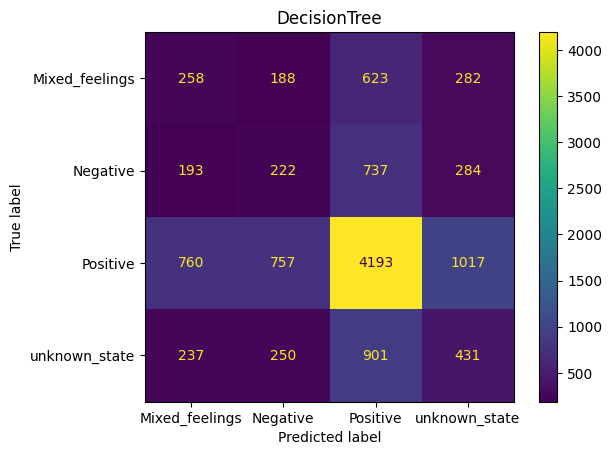

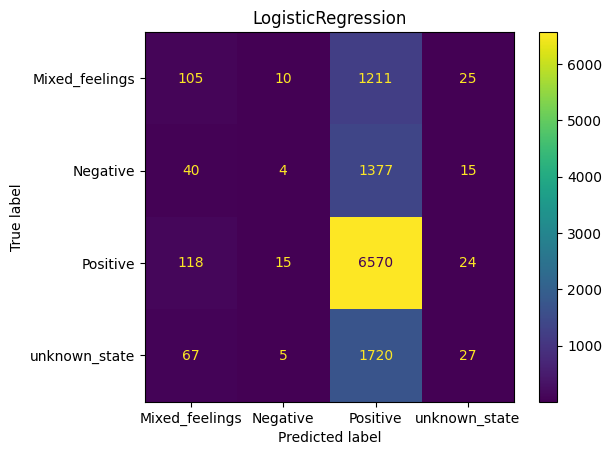

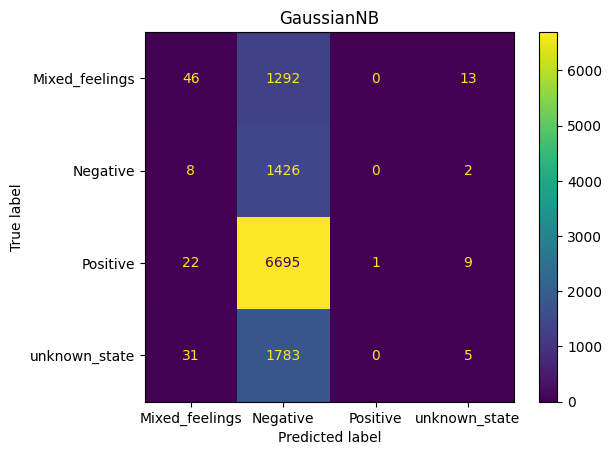

In [ ]:
for i in range(4):
    cm[i].plot()
    plt.title(algo_names[i])
    plt.show()

# **Deep Learning**

**LSTM Model**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=dset_vocab_size, output_dim=100, input_length=200))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=np.max(y_train) + 1, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(x_train, y_train, epochs=3, batch_size=128, validation_data=(x_test, y_test))

loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          7203200   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 7320964 (27.93 MB)
Trainable params: 7320964 (27.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
207/207 [==============================] - 243s 1s/step - loss: 1.1288 - accuracy: 0.5899 - val_loss: 1.1198 - val_accuracy: 0.5936
Epoch 2/3
207/207 [==============================] - 220s 1s/step - loss: 1.1248 - accuracy: 0.5900 - val_loss: 1.1188 - val_accura

In [ ]:
# Assuming you have already trained and compiled your model as mentioned in your previous code
# Use your trained model to make predictions on the test dataset
y_pred = model.predict(x_test)

# Evaluate the model on the test dataset to get test loss and accuracy
loss, accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# You can also view the predicted labels for individual data points
predicted_labels = [np.argmax(pred) for pred in y_pred]

# If you want to view the predicted labels alongside the true labels
for i in range(len(y_test)):
    print(f"True Label: {y_test[i]}, Predicted Label: {predicted_labels[i]}")


Streaming output truncated to the last 5000 lines.
True Label: 3, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 0, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 3, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 0, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 2
True Label: 1, Predicted Label: 2
True Label: 1, Predicted Label: 2
True Label: 0, Predicted Label: 2
True Label: 3, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 3, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 3, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 3, Predicted Label: 2
True Label: 0, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 3, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 2
True Label: 0, Predicted Label:

In [ ]:
# import pandas as pd
# data = pd.DataFrame({'Text': x_new_data, 'Predicted_Labels': predicted_labels})
# data.to_csv('predicted_data.csv', index=True)

**HuggingFace pretrained maodel**

In [ ]:
!pip install transformers datasets

In [ ]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
classifier("Hello! thanks for giving the results")

[{'label': 'POSITIVE', 'score': 0.9997366070747375}]

In [ ]:
results = classifier(["Thanks a lot","I am not fine"])
for result in results:
  print(f"label: {result['label']}, with score : {round(result['score'], 4)}")

label: POSITIVE, with score : 0.9998
label: NEGATIVE, with score : 0.9997


In [ ]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/content/drive/MyDrive/sen_tam_test_without_labels.csv"

# Read the first few rows of the CSV file
data = pd.read_csv(csv_file_path)
print(data.head())


       id                                               Text
0  TAM_01                         இது புதுவகை கொள்ளை கூட்டம்
1  TAM_02  சுட்டுக்கொல்ல வேண்டும் அல்லது குண்டர் சட்டத்தி...
2  TAM_03  இந்த திருநங்கைகள் பொதுமக்களுக்கு பொது இடங்களில...
3  TAM_04  அராஜகம் செய்து தங்களுடைய மதிப்பை தாங்களே கெடுத...
4  TAM_05  தவறான விடையம் சகோ...அந்த பொண்டுகப் புண்டாமகன்ள...


In [ ]:
text_data = data['Text'].tolist()

In [ ]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")
csv_file_path = "/content/drive/MyDrive/sen_tam_test_without_labels.csv"
data = pd.read_csv(csv_file_path)
text_data = data['Text'].tolist()
results = classifier(text_data)

# Print or process the sentiment analysis results
for result in results:
    print(result)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'label': 'POSITIVE', 'score': 0.7178416848182678}
{'label': 'POSITIVE', 'score': 0.6783708930015564}
{'label': 'NEGATIVE', 'score': 0.9084221124649048}
{'label': 'NEGATIVE', 'score': 0.6550226807594299}
{'label': 'NEGATIVE', 'score': 0.7578939199447632}
{'label': 'NEGATIVE', 'score': 0.9816615581512451}
{'label': 'POSITIVE', 'score': 0.6065110564231873}
{'label': 'POSITIVE', 'score': 0.5699513554573059}
{'label': 'POSITIVE', 'score': 0.8804948925971985}
{'label': 'NEGATIVE', 'score': 0.9635543823242188}
{'label': 'NEGATIVE', 'score': 0.8832130432128906}
{'label': 'POSITIVE', 'score': 0.7202191352844238}
{'label': 'NEGATIVE', 'score': 0.9631556272506714}
{'label': 'POSITIVE', 'score': 0.8668987154960632}
{'label': 'NEGATIVE', 'score': 0.5007611513137817}
{'label': 'NEGATIVE', 'score': 0.7891495823860168}
{'label': 'NEGATIVE', 'score': 0.5152385234832764}
{'label': 'POSITIVE', 'score': 0.6250746250152588}
{'label': 'NEGATIVE', 'score': 0.9866359829902649}
{'label': 'POSITIVE', 'score': 

In [ ]:
from transformers import pipeline
import pandas as pd

# Create the sentiment analysis pipeline
classifier = pipeline("sentiment-analysis")

# Specify the path to your CSV file
csv_file_path = "/content/drive/MyDrive/sen_tam_test_without_labels.csv"

# Read the text data from the CSV file
data = pd.read_csv(csv_file_path)

# Assuming the text data is stored in a column named 'Text' in the CSV file
text_data = data['Text'].tolist()

# Use the classifier to predict sentiment for the entire text dataset
results = classifier(text_data)
# Extract sentiment labels and scores from the results
sentiment_labels = [result['label'] for result in results]
sentiment_scores = [result['score'] for result in results]

# Add the sentiment labels and scores to the DataFrame
data['Sentiment_Label'] = sentiment_labels
data['Sentiment_Score'] = sentiment_scores

# Save the DataFrame to a new CSV file
output_csv_file = "/content/drive/MyDrive/sentiment_analysis_results.csv"
data.to_csv(output_csv_file, index=False)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


**Bert Model**

In [ ]:
# label_encoder = LabelEncoder()
# bert_x,bert_y=dset.text,label_encoder.fit_transform(dset.category.values)
# bx_train, bx_test, by_train, by_test = train_test_split(
#     bert_x,
#     bert_y,
#     test_size=0.3,
#     random_state=42
# )

In [ ]:
# bx_train=bx_train.apply(lambda x:' '.join(x))
# bx_test=bx_test.apply(lambda x:' '.join(x))

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# x_train_encodings = bx_train.apply(lambda x:tokenizer.encode(' '.join(x), truncation=True, padding=True, max_length=200))
# bx= x_test_encodings = bx_test.apply(lambda x:tokenizer.encode(' '.join(x), truncation=True, padding=True, max_length=200))

In [ ]:
# len(x_train_encodings.tolist())

In [ ]:
# bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=model.compute_loss)
# bert_model.fit(
#    torch.tensor(x_train_encodings.tolist()),
#     y_train,
#     epochs=3,
#     batch_size=128,
#     validation_data=(torch.tensor(x_test_encodings.tolist()), y_test)
# )

In [ ]:
# results = bert_model.evaluate(x_test_encodings.input_ids, y_test)
# print("Test loss:", results[0])
# print("Test accuracy:", results[1])